In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import openpyxl
import shap

In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'



In [3]:
final_df = pd.read_csv(interim_dir/'sims_notnull_200125.csv', index_col = [1,2])

In [4]:
final_df = (final_df
 .drop(['Unnamed: 0'], axis = 1)
 .assign(label = lambda df: df['Label'].apply(lambda x: 1 if x == 0 else 0))
 .drop(['Label'], axis = 1)
)

In [5]:
final_df['label'].value_counts()

label
0    187710
1      2943
Name: count, dtype: int64

In [6]:
final_df = (final_df.reset_index()
 .assign(pair = lambda df: df.apply(lambda row: tuple(sorted([row["Target"], row["Analogue"]])), axis=1)
        )
.drop_duplicates(subset=["pair"]).drop(columns=["pair"])
)
# Drop duplicate pairs
#df_unique = df.drop_duplicates(subset=["Pair"]).drop(columns=["Pair"])


In [7]:
similar_pairs = final_df[final_df['label'] == 1]
dissimilar_pairs = final_df[final_df['label'] ==0]

# Step 2: Downsample dissimilar pairs
downsampled_dissimilar_pairs = dissimilar_pairs.sample(n=len(similar_pairs), replace=False)

# Step 3: Combine balanced pairs
balanced_df = pd.concat([similar_pairs, downsampled_dissimilar_pairs])

# Step 4: Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42)

In [8]:
balanced_df[balanced_df['label'] ==1]

,Target,Analogue,analogue_smi,target_smi,S_struct,S_react,S_physchem,S_metab,label
16369,DTXSID2059693,DTXSID7044764,CC(C)C(=O)OCCC1=CC=CC=C1,CC(C)CC(=O)OCCC1=CC=CC=C1,0.613636,1.0,0.937321,0.193775,1
174169,DTXSID90286896,DTXSID3051545,CCOCCOC(=O)C=C,COCCOC(=O)CC(=C)C(=O)OCCOC,0.220000,1.0,0.734494,0.000000,1
89267,DTXSID2063553,DTXSID10862696,CC=CC(C)O,CC=C(C)CO,0.190476,0.0,0.995166,0.000000,1
147216,DTXSID50274032,DTXSID60860420,CC(C)CCCCCCOC(=O)C1=C(C=CC=C1)C(=O)OCCCCCCC(C)C,CC(C)CCCCCCCOC(=O)C1=C(C=CC=C1)C(=O)OCCCCCCCC(C)C,0.975610,1.0,0.961196,0.200000,1
184528,Pubchem_102283665,DTXSID9026342,OCCC1=CC=CC=C1,CCCCCCCCCC(=O)OCCCC1=CC=CC=C1,0.301887,1.0,0.533034,0.000000,1
...,...,...,...,...,...,...,...,...,...
108536,DTXSID7032638,DTXSID9047542,COC=C(C(=O)OC)C1=CC=CC=C1COC1=CC=CC(=N1)C(F)(F)F,CON(C(=O)OC)C1=C(COC2=NN(C=C2)C2=CC=C(Cl)C=C2)...,0.209091,1.0,0.966728,0.088852,1
13143,DTXSID1024621,DTXSID3025047,CCOCCOCCOCC,COCCOCCOC,0.350000,1.0,0.937090,0.000000,1
189415,DTXSID5024182,DTXSID3051545,CCOCCOC(=O)C=C,COCCO,0.142857,0.0,0.772129,0.000000,1
33453,DTXSID2061434,DTXSID3027792,CC[Si](OC(C)=O)(OC(C)=O)OC(C)=O,C[Si](C)(O)O,0.142857,1.0,0.563695,0.000000,1


In [43]:
balanced_df = balanced_df.set_index(['Target', 'Analogue'])

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
y = balanced_df['label'].values

In [46]:
balanced_df.columns

Index(['analogue_smi', 'target_smi', 'S_struct', 'S_react', 'S_physchem',
       'S_metab', 'label'],
      dtype='object')

In [47]:
X = balanced_df[[ 'S_struct', 'S_react', 'S_physchem',
       'S_metab']]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=42)

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_validate, train_test_split

In [50]:
lr = LogisticRegression()

In [51]:
cv = StratifiedKFold(n_splits = 10)
scorer = make_scorer(balanced_accuracy_score)

In [52]:
cv_scores = cross_validate(lr, X_train, y_train, cv = cv, scoring=scorer, n_jobs = -1)
cv_scores = pd.DataFrame(cv_scores)

In [54]:
cv_scores['test_score'].mean()

0.9186538461538462

In [55]:
lr.fit(X_train, y_train)
preds = lr.predict(X_test)


In [56]:
cm2 = confusion_matrix(y_test, preds)
cm2

array([[698,  38],
       [ 59, 677]])

In [57]:
lr.coef_

array([[13.90768957,  1.32607406,  6.24515836,  2.50671579]])

In [58]:
X_train

,,S_struct,S_react,S_physchem,S_metab
Target,Analogue,,,,
DTXSID6035156,DTXSID4063909,0.580000,1.0,0.787021,0.198408
DTXSID00883754,DTXSID00885379,0.083333,1.0,0.751836,0.000000
DTXSID2021311,DTXSID3021641,0.047619,1.0,0.727068,0.000000
DTXSID2061434,DTXSID80168576,0.052632,1.0,0.809446,0.000000
DTXSID9063904,Pubchem_102283661,0.672727,1.0,0.931859,0.000000
...,...,...,...,...,...
DTXSID0020575,DTXSID60144035,0.025000,0.0,0.600491,0.304604
DTXSID4020298,DTXSID2041416,0.000000,1.0,0.837302,0.000000
DTXSID9026714,DTXSID0074716,0.454545,1.0,0.914808,0.000000


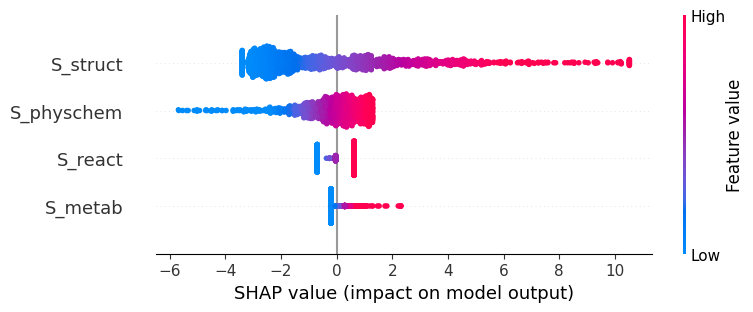

In [59]:

explainer = shap.Explainer(lr, X_train, feature_names=X_train.columns)
shap_values = explainer(X_test)
# Calculate SHAP values
shap.plots.beeswarm(shap_values)

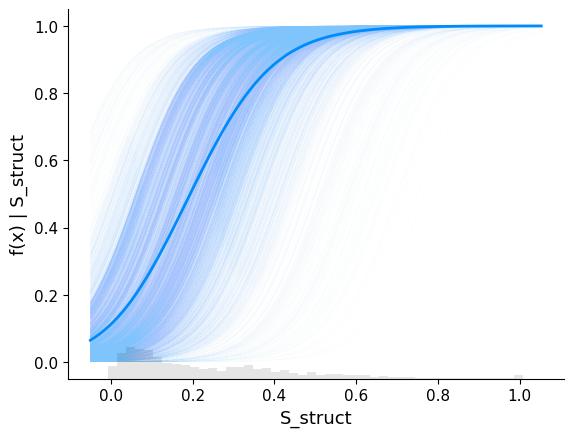

In [60]:
shap.partial_dependence_plot("S_struct", lambda x: lr.predict_proba(x)[:, 1], X_train)

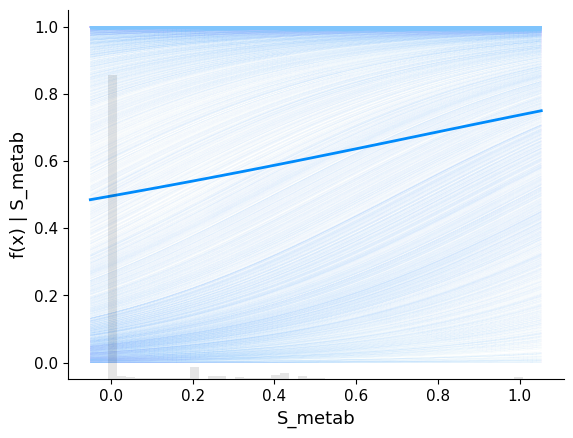

In [61]:
shap.partial_dependence_plot("S_metab", lambda x: lr.predict_proba(x)[:, 1], X_train)

In [69]:
explainer = shap.KernelExplainer(lr.predict_proba, shap.kmeans(X_train, 10))

# Compute SHAP values for the first instance in X
shap_values = explainer.shap_values(X_test.loc[('DTXSID6021741', 	'DTXSID7021946'),:])


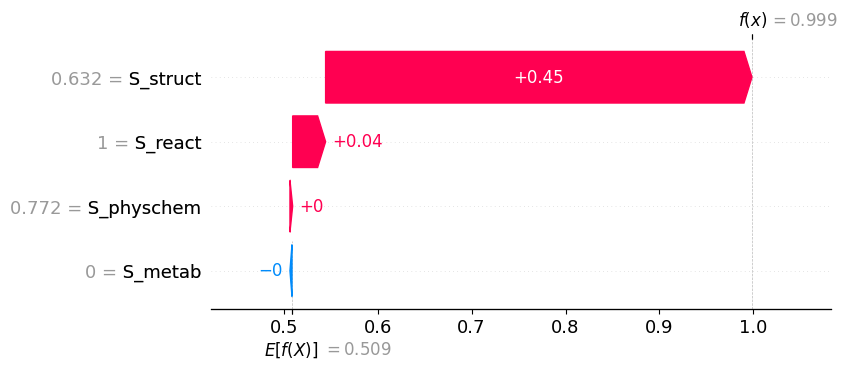

In [70]:
shap.waterfall_plot(shap.Explanation( values=shap_values[:,1],    base_values=explainer.expected_value[1],    data=X_test.loc[('DTXSID6021741', 	'DTXSID7021946'),:],    feature_names = X.columns))